# Intermediate TextMining with Python

 By: Dr. Eric Godat and Dr. Rob Kalescky
 
 Acknowledgements: Garrett Moore, Jaymie Ruddock

 Adapted from: [Ultimate Guide to deal with Text Data (Using Python)](https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/)
 
 Natural Language Toolkit: [Documentation](http://www.nltk.org/)
 
 Reference Text: [Natural Language Processing with Python](http://www.nltk.org/book/)
 
 
 *This notebook follows the **Introduction to Working with Text Data** lesson. Please consider looking over that lesson if you have not already*

## Setup

These are the basic libraries we will use in for data manipulation (pandas) and math functions (numpy). We will add more libraries as we need them.

As a best practice, it is a good idea to load all your libraries in a single cell at the top of a notebook, however for the purposes of this tutorial we will load some now and more as we go.

In [1]:
%config InlineBackend.figure_format ='retina'

In [2]:
import pandas as pd
import numpy as np
import glob

Load a data file into a pandas DataFrame.

This tutorial was designed around using sets of data you have yourselves in a form like a CSV, TSV, or TXT file.  Feel free to use any set of data, but for now we will use a dataset created from scraping this [Multilingual Folktale Database](http://www.mftd.org/).

This file is a CSV filetype, common for text data, but your data may also be stored as TSV's, TXT's, or other file types.  This will slightly change how you read from Pandas, but the concept is largely the same for the different filetypes.  Just keep this in mind when you see references to CSV.

To proceed, you will need to have this file downloaded and in the same folder as this notebook. Alternatively you can put the full path to the file.  Typically, your program will look for the file with the name you specified in the folder that contains your program unless you give the program a path to follow.

In [3]:
glob.glob("*.csv") #Allows us to check the files in the current directory, if folktales.csv is not here, then we need to give the path

['folktales.csv']

In [4]:
filename = 'folktales.csv' #If you need to put the path to the file, do so here.
data = pd.read_csv(filename)#if your filetype is not CSV, you may need to add " , sep = 'separating_character_here' " after the filename.  This may require extra manipulation, so be careful.
#an alternative, depending on your filetype and situation, may be read_table as opposed to read_csv
data.rename(columns={'Unnamed: 0':'Index'},inplace=True) # Rename our index column
data.head() # We will use the .head() attribute to limit the amount of the DataFrame is displayed on screen. It is not necessary for computation.

,Index,ATU Code,Author,Country of Origin,Original Title,Source,Story,Story Type,Title,Translated,Year Translated,Year Written
0,17,15.0,Jacob & Wilhelm Grimm,Germany,Katze und Maus in Gesellschaft,NaN,"A cat had made the acquaintance of a mouse, an...",Stealing the Partner's Butter (ATU 15)\n\t\t,Cat and mouse in partnership,Margaret Hunt,1884.0,1812
1,44,123.0,Jacob & Wilhelm Grimm,Germany,Der Wolf und die sieben jungen Geisslein,NaN,There was once an old goat who had seven littl...,The Wolf and the Seven Young Kids (ATU 123)\n...,The Wolf and the Seven Young Kids,Margaret Hunt,1884.0,1812
2,54,516.0,Jacob & Wilhelm Grimm,Germany,Der treue Johannes,The Blue Fairy Book (nr. 30),ONCE upon a time there was an old king who was...,The Petrified Friend (ATU 516)\n\t\t,Trusty John,Andrew Lang,1889.0,1812
3,64,NaN,Jacob & Wilhelm Grimm,Germany,Der gute Handel,NaN,There was once a peasant who had driven his co...,NaN,The good bargain,Margaret Hunt,1884.0,1812
4,74,151.0,Jacob & Wilhelm Grimm,Germany,Der wunderliche Spielmann,NaN,"There was once a wonderful musician, who went ...",Music lessons for wild animals (ATU 151)\n\t\t,The Wonderful Musician,Translated into English,NaN,1812


Here we can see all the information available to us from the file in the form of a Pandas DataFrame. For the remainder of this tutorial, we will focus primarily on the full text of each data chunk, which we will name the *Story* column.  With your data set this is likely to be something very different, so feel free to call is something else.

## EDGAR Database

Here is the [homepage](https://www.sec.gov/edgar.shtml) for the Securities and Exchange Commission's EDGAR database. If you are having trouble finding a specific company, try their [full text search](https://www.sec.gov/edgar/search/#).

Usage documentation for the Python package can be found [here](https://pypi.org/project/edgar/).

Pull the last 5 10-K reports for the Oracle Corporation

In [5]:
from edgar import Company, TXTML
company = Company("Oracle Corp", "0001341439")
tree = company.get_all_filings(filing_type = "10-K")
docs = Company.get_documents(tree, no_of_documents=5)

Parse the most recent 10-K filing for IBM

In [6]:
company = Company("INTERNATIONAL BUSINESS MACHINES CORP", "0000051143")
doc = company.get_10K()
text = TXTML.parse_full_10K(doc)

Search EDGAR for a company Cisco System

In [7]:
from edgar import Edgar
edgar = Edgar()
possible_companies = edgar.find_company_name("Cisco System")
possible_companies

['CISCO SYSTEMS (SWITZERLAND) INVESTMENTS LTD',
 'CISCO SYSTEMS CAPITAL CORP',
 'CISCO SYSTEMS INC',
 'CISCO SYSTEMS INTERNATIONAL B.V.',
 'CISCO SYSTEMS, INC.',
 'L3TV SAN FRANCISCO CABLE SYSTEM, LLC',
 'SPANISH BROADCASTING SYSTEM SAN FRANCISCO INC']

### Simple Example

In [8]:
companies = [['AMAZON COM INC','0001018724'],
            ['Alphabet Inc.','0001652044'],
            ['MICROSOFT CORP','0000789019']
            ]

In [9]:
edgarDF = pd.DataFrame(companies, columns=['Company','CIK'])
edgarDF['MostRecent_10K']=edgarDF.apply(lambda row: TXTML.parse_full_10K(Company(row['Company'],row['CIK']).get_10K()) , axis=1)
edgarDF

,Company,CIK,MostRecent_10K
0,AMAZON COM INC,0001018724,\n\n\n\n\namzn-20201231false2020FY0001018724P3...
1,Alphabet Inc.,0001652044,\n\n\n\n\ngoog-20201231FALSE2020FY0001652044P7...
2,MICROSOFT CORP,0000789019,\n\n\n\n\n\n\n\n\n\n\nmsft-10k_20200630.htm\n\...


#### Last 5 10Ks with Filing Dates

In [10]:
def get_edgar(ll, n):
    filinglist = []
    for el in ll:
        company = Company(el[0], el[1])
        tree = company.get_all_filings(filing_type = "10-K")
        docs = Company.get_documents(tree, no_of_documents=n, as_documents=True)
        texts = Company.get_documents(tree, no_of_documents=n, as_documents=False)
        if n<2:
            docs=[docs]
            texts=[texts]
        for i in range(n):
            date = docs[i].content['Filing Date']
            text = TXTML.parse_full_10K(texts[i])
            filinglist.append([el[0],el[1],date,text])
    df = pd.DataFrame(filinglist, columns=['Title','CIK','10K_Filing','Story'])
    return df

In [86]:
data = get_edgar(companies,5)

data = data.reset_index()
data.rename(columns={'index':'Index'},inplace=True)

In [87]:
data

,Index,Title,CIK,10K_Filing,Story
0,0,AMAZON COM INC,0001018724,2021-02-03,\n\n\n\n\namzn-20201231false2020FY0001018724P3...
1,1,AMAZON COM INC,0001018724,2020-01-31,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...
2,2,AMAZON COM INC,0001018724,2019-02-01,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...
3,3,AMAZON COM INC,0001018724,2018-02-02,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...
4,4,AMAZON COM INC,0001018724,2017-02-10,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...
5,5,Alphabet Inc.,0001652044,2021-02-03,\n\n\n\n\ngoog-20201231FALSE2020FY0001652044P7...
6,6,Alphabet Inc.,0001652044,2020-02-04,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...
7,7,Alphabet Inc.,0001652044,2019-02-06,\n\nAmendment No. 1 to Form 10-K\n\n \n\n \...
8,8,Alphabet Inc.,0001652044,2019-02-05,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nUN...
9,9,Alphabet Inc.,0001652044,2018-02-06,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nUN...


## Counting Words and Characters

The first bit of analysis we might want to do is to count the number of words in one piece of data. To do this we will add a column called *wordcount* and write an operation that applies a function to every row of the column.

Unpacking this piece of code, *len(str(x).split(" ")*, tells us what is happening.

For the content of cell *x*, convert it to a string, *str()*, then split that string into pieces at each space, *split()*.

The result of that is a list of all the words in the text and then we can count the length of that list, *len()*.

In [41]:
data['wordcount'] = data['Story'].apply(lambda x: len(str(x).split(" ")))
data[['Story','wordcount']].head()

,Story,wordcount
0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,34933
1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,36029
2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,35638
3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,38136
4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,35826


We can do something similar to count the number of characters in the data chunk, including spaces. If you wanted to exclude whitespaces, you could take the list we made above, join it together and count the length of the resulting string.

In [42]:
data = data.fillna("No Information Provided") #If some of our data is missing, this will replace the blank entries. This is only necessary in some cases

In [43]:
data['char_count'] = data['Story'].str.len() ## this also includes spaces, to do it without spaces, you could use something like this: "".join()
data[['Story','char_count']].head()

,Story,char_count
0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,274004
1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,305025
2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,260659
3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,278259
4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,264663


Now we want to calculate the average word length in the data.

Let's define a function that will do that for us:

In [44]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

We can now apply that function to all the data chunks and save that in a new column.

In [45]:
data['avg_word'] = data['Story'].apply(lambda x: avg_word(x))
data[['Story','avg_word']].head()

,Story,avg_word
0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,6.652604
1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,6.460655
2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,5.941362
3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,5.933047
4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,5.977988


We can then sort by the average word length.

In [46]:
data[['Story','avg_word']].sort_values(by='avg_word', ascending=True).head()

,Story,avg_word
7,\n\nAmendment No. 1 to Form 10-K\n\n \n\n \...,5.301764
12,\n\n\n\n\nmsft-10k_20180630.htm\n\n\n\n\n\n \n...,5.546546
14,\n\n10-K\n\n \nTable of Contents\n\n\n\n UNITE...,5.553925
13,\n\n\n\n\nmsft-10k_20170630.htm\n\n\n\n\n\n \n...,5.575125
11,\n\n\n\n\nmsft-10k_20190630.htm\n\n\n\n\n\n \n...,5.580830


# Processing Text

A major component of doing analysis on text is the cleaning of the text prior to the analysis.

Though this process destroys some elements of the text (sentence structure, for example), it is often necessary in order to describe a text analytically. Depending on your choice of cleaning techniques, some elements might be preserved better than others if that is of importance to your analysis.

## Cleaning Up Words

This series of steps aims to clean up and standardize the text itself. This generally consists of removing common elements such as stopwords and punctuation but can be expanded to more detailed removals.

### Lowercase

Here we enforce that all of the text is lowercase. This makes it easier to match cases and sort words.

Notice we are assigning our modified column back to itself. This will save our modifications to our DataFrame

In [47]:
data['Story'] = data['Story'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data['Story'].head()

0    amzn-20201231false2020fy0001018724p3yp1yp1yus-...
1    document 0.5p1yp1yp1y0029000000false--12-31fy2...
2    document table of contents united statessecuri...
3    document united statessecurities and exchange ...
4    document united statessecurities and exchange ...
Name: Story, dtype: object

### Remove Punctuation

Here we remove all punctuation from the data. This allows us to focus on the words only as well as assist in matching.

In [48]:
data['Story'] = data['Story'].str.replace('[^\w\s]','')
data['Story'].head()

0    amzn20201231false2020fy0001018724p3yp1yp1yusga...
1    document 05p1yp1yp1y0029000000false1231fy20190...
2    document table of contents united statessecuri...
3    document united statessecurities and exchange ...
4    document united statessecurities and exchange ...
Name: Story, dtype: object

### Remove Stopwords

Stopwords are words that are commonly used and do little to aid in the understanding of the content of a text. There is no universal list of stopwords and they vary on the style, time period and media from which your text came from.  Typically, people choose to remove stopwords from their data, as it adds extra clutter while the words themselves provide little to no insight as to the nature of the data.  For now, we are simply going to count them to get an idea of how many there are.

For this tutorial, we will use the standard list of stopwords provided by the Natural Language Toolkit python library.

In [49]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
data['Story'] = data['Story'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data['Story'].head()

0    amzn20201231false2020fy0001018724p3yp1yp1yusga...
1    document 05p1yp1yp1y0029000000false1231fy20190...
2    document table contents united statessecuritie...
3    document united statessecurities exchange comm...
4    document united statessecurities exchange comm...
Name: Story, dtype: object

### Remove Frequent Words

If we want to catch common words that might have slipped through the stopword removal, we can build out a list of the most common words remaining in our text.

Here we have built a list of the 10 most common words. Some of these words might actually be relevant to our analysis so it is important to be careful with this method.

In [50]:
freq = pd.Series(' '.join(data['Story']).split()).value_counts()[:10]
freq

may          2773
services     2746
tax          2715
income       2609
financial    2463
billion      2189
us           2160
products     2142
revenue      2120
cash         2094
dtype: int64

We now follow the same procedure with which we removed stopwords to remove the most frequent words.

In [51]:
freq = list(freq.index)
data['Story'] = data['Story'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
data['Story'].head()

0    amzn20201231false2020fy0001018724p3yp1yp1yusga...
1    document 05p1yp1yp1y0029000000false1231fy20190...
2    document table contents united statessecuritie...
3    document united statessecurities exchange comm...
4    document united statessecurities exchange comm...
Name: Story, dtype: object

## Lemmatization

Lemmatization is often a more useful approach than stemming because it leverages an understanding of the word itself to convert the word back to its root word. However, this means lemmatization is less aggressive than stemming (probably a good thing).

In [52]:
#import nltk
#nltk.download('wordnet')

In [53]:
from textblob import Word
data['Story'] = data['Story'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
data['Story'].head()

0    amzn20201231false2020fy0001018724p3yp1yp1yusga...
1    document 05p1yp1yp1y0029000000false1231fy20190...
2    document table content united statessecurities...
3    document united statessecurities exchange comm...
4    document united statessecurities exchange comm...
Name: Story, dtype: object

At this point we have a several options for cleaning and structuring our text data. The next section will focus on more advanced ways to study text analytically.

# Advanced Text Processing

This section focuses on more complex methods of analyzing textual data. We will continue to work with our same DataFrame.

## N-grams

N-grams are combinations of multiple words as they appear in the text. The N refers to the number of words captured in the list. N-grams with N=1 are referred unigrams and are just a nested list of all the words in the text. Following a similar pattern, bigrams (N=2), trigrams (N=3), etc. can be used.

N-grams allow you to capture the structure of the text which can be very useful. For instance, counting the number of bigrams where "said" was preceded by "he" vs "she" could give you an idea of the gender breakdown of speakers in a text. However, if you make your N-grams too long, you lose the ability to make comparisons.

Another concern, especially in very large data sets, is that the memory storage of N-grams scales with N (bigrams are twice as large as unigrams, for example) and the time to process the N-grams can balloon dramatically as well.

All that being said, we would suggest focusing on bigrams and trigrams as useful analysis tools.

In [54]:
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

lemmatizer = WordNetLemmatizer()
n_grams = TextBlob(data['Story'][1]).ngrams(2)

In [55]:
characters=[]
for i in ['wolf', 'mouse', 'rabbit', 'children']:
     characters.append(lemmatizer.lemmatize(i))

In [56]:
for n in n_grams:
    if n[1] in characters:
        print(n)

In [57]:
from nltk import ngrams
from collections import Counter

ngram_counts = Counter(ngrams(data['Story'][1].split(), 2))
for n in ngram_counts.most_common(10):
    print(n)

(('december', '31'), 167)
(('20191231', '0001018724'), 128)
(('20181231', '0001018724'), 112)
(('2018', '2019'), 74)
(('20171231', '0001018724'), 69)
(('31', '2019'), 63)
(('20190101', '20191231'), 61)
(('ended', 'december'), 57)
(('consolidated', 'statement'), 55)
(('31', '2018'), 55)


## Term Frequency

Term Frequency is a measure of how often a term appears in a document. There are different ways to define this but the simplest is a raw count of the number of times each term appears.

There are other ways of defining this including a true term frequency and a log scaled definition. All three have been implemented below but the default will the raw count definition, as it matches with the remainder of the definitions in this tutorial.

|Definition|Formula|
|---|---|
|Raw Count|$$f_{t,d}$$|
|Term Frequency|$$\frac{f_{t,d}}{\sum_{t'\in d}f_{t',d}}$$|
|Log Scaled|$$\log(1+f_{t,d})$$|



In [58]:
## Raw Count Definition
tf1 = (data['Story'][0:5]).apply(lambda x: pd.value_counts(x.split(" "))).sum(axis = 0).reset_index()

## Term Frequency Definition
#tf1 = (data['Story'][0:5]).apply(lambda x: (pd.value_counts(x.split(" ")))/len(x.split(" "))).sum(axis = 0).reset_index() 

## Log Scaled Definition
#tf1 = (data['Story'][0:10]).apply(lambda x: 1.0+np.log(pd.value_counts(x.split(" ")))).sum(axis = 0).reset_index() 

tf1.columns = ['words','tf']
tf1.sort_values(by='tf', ascending=False)[:10]

,words,tf
1,december,971.0
9,million,937.0
2,31,878.0
3,sale,823.0
4,cost,771.0
5,operating,680.0
7,net,668.0
361,2017,626.0
6,including,619.0
11,result,581.0


## Inverse Document Frequency

Inverse Document Frequency is a measure of how common or rare a term is across multiple documents. That gives a measure of how much weight that term carries.

For a more concrete analogy of this, imagine a room full of NBA players; here a 7 foot tall person wouldn't be all that shocking. However if you have a room full of kindergarten students, a 7 foot tall person would be a huge surprise.

The simplest and standard definition of Inverse Document Frequency is to take the logarithm of the ratio of the number of documents containing a term to the total number of documents.

$$-\log\frac{n_t}{N} = \log\frac{N}{n_t}$$


In [59]:
for i,word in enumerate(tf1['words']):
    tf1.loc[i, 'idf'] = np.log(data.shape[0]/(len(data[data['Story'].str.contains(word)])))

tf1[:10]

,words,tf,idf
0,2020,228.0,0.068993
1,december,971.0,0.000000
2,31,878.0,0.000000
3,sale,823.0,0.000000
4,cost,771.0,0.068993
5,operating,680.0,0.068993
6,including,619.0,0.000000
7,net,668.0,0.068993
8,lease,547.0,0.068993
9,million,937.0,0.068993


## Term Frequency – Inverse Document Frequency ([TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf))

Term Frequency – Inverse Document Frequency (TF-IDF) is a composite measure of both Term Frequency and Inverse Document Frequency.

From [Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf):
"A high weight in TF–IDF is reached by a high term frequency (in the given document) and a low document frequency of the term in the whole collection of documents; the weights hence tend to filter out common terms"

More concisely, a high TD-IDF says that a word is very important in the documents in which it appears.

There are a few weighting schemes for TF-IDF. Here we use scheme (1).

|Weighting Scheme|Document Term Weight|
|---|---|
|(1)|$$f_{t,d}\cdot\log\frac{N}{n_t}$$|
|(2)|$$1+\log(f_{t,d})$$|
|(3)|$$(1+\log(f_{t,d}))\cdot\log\frac{N}{n_t}$$|

In [60]:
tf1['tfidf'] = tf1['tf'] * tf1['idf']
tf1.sort_values(by='tfidf', ascending=False)[:10]

,words,tf,idf,tfidf
4413,0001018724,348.0,2.014903,701.186251
153,amazoncom,202.0,1.098612,221.919682
4414,20191231,128.0,1.098612,140.622373
41,seller,311.0,0.405465,126.099649
4415,20181231,113.0,1.098612,124.143189
195,shipping,132.0,0.916291,120.950377
875,food,77.0,1.321756,101.775200
4419,20170101,47.0,2.014903,94.700442
4416,20171231,69.0,1.098612,75.804248
512,prime,64.0,1.098612,70.311186


It is worth noting that the *sklearn* library has the ability to directly calculate a TD-IDF matrix.

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',
 stop_words= 'english',ngram_range=(1,1))
data_vect = tfidf.fit_transform(data['Story'])

data_vect

<15x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 13391 stored elements in Compressed Sparse Row format>

## Similarity

In [62]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # This suppresses a warning from scikit learn that they are going to update their code

One thing we can look at is how similar two texts are. This has a practical use when looking for plagiarism, but can also be used to compare author's styles. To do this there are a few ways we can measure similarity.

First we need to set up our two sets of texts. Here we have the ability to choose the size of our sets and whether we want the first n texts from our full data set or just a random sample. Keep in mind that if you want to use two dissimilar sets, you won't have a control value (something x itself).

In [63]:
size=10

In [88]:
## First n by First n
set1 = data[["Index",'Story','Title']][:size]
set2 = data[["Index",'Story','Title']][:size]

## Random X Itself
#set1 = data[["Index",'Story','Title']].sample(size)
#set2 = set1

## First n by Random
#set1 = data[["Index",'Story','Title']][:size]
#set2 = data[["Index",'Story','Title']].sample(size)

## Random X Random
#set1 = data[["Index",'Story','Title']].sample(size)
#set2 = data[["Index",'Story','Title']].sample(size)

In [89]:
#To let us do a "cross join": Every row in one gets matched to all rows in the other
set1['key']=1 
set2['key']=1

similarity = pd.merge(set1, set2, on ='key', suffixes=('_1', '_2')).drop("key", 1)

### Jaccard Similarity

The first is using a metric called the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index). This is just taking the intersection of two sets of things (in our case, words or n-grams) and dividing it by the union of those sets. This gives us a metric for understanding how the word usage compares but doesn't account for repeated words since the union and intersections just take unique words. One advantage though is that we can easily extend the single word similarity to compare bi-grams and other n-grams if we want to examine phrase usage.

$$S_{J}(A,B)=\frac{A \cap B}{A \cup B}$$


In [90]:
def jaccard(row, n=1):
    
    old=row['Story_1']
    new=row['Story_2']
    
    old_n_grams = [tuple(el) for el in TextBlob(old).ngrams(n)]
    new_n_grams = [tuple(el) for el in TextBlob(new).ngrams(n)]
        
    union = list(set(old_n_grams) | set(new_n_grams))
    intersection = list(set(old_n_grams) & set(new_n_grams))
    
    lu = len(union)
    li = len(intersection)
    
    return (li/lu,li,lu)

In [91]:
for i in [1,2]: # Add values to the list for the n-gram you're interested in
    similarity['Jaccard_Index_for_{}_grams'.format(i)]=similarity.apply(lambda x: jaccard(x,i)[0],axis=1)

In [92]:
similarity['Intersection']=similarity.apply(lambda x: jaccard(x)[1],axis=1)

In [93]:
similarity['Union']=similarity.apply(lambda x: jaccard(x)[2],axis=1)

In [94]:
similarity.head()

,Index_1,Story_1,Title_1,Index_2,Story_2,Title_2,Jaccard_Index_for_1_grams,Jaccard_Index_for_2_grams,Intersection,Union
0,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,1.000000,1.000000,5660,5660
1,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,AMAZON COM INC,0.563524,0.617675,4094,7265
2,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,AMAZON COM INC,0.499061,0.521214,3719,7452
3,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,AMAZON COM INC,0.466623,0.453437,3572,7655
4,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,AMAZON COM INC,0.445435,0.425136,3449,7743


### Cosine Similarity

The second metric we can use is [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity), however there is a catch here. Cosine similarity requires a vector for each word so we make a choice here to use term frequency. You could choose something else, inverse document frequency or tf-idf would both be good choices. Cosine similarity with a term frequency vector gives us something very similar to the Jaccard Index but accounts for word repetition. This makes it better for tracking word importance between two texts.

$$S_{C}(v_1,v_2)=cos(\theta)=\frac{v_1\cdot v_2}{||v_1||\times||v_2||}$$

In [95]:
def get_cosine_sim(str1,str2): 
    vectors = [t for t in get_vectors([str1,str2])]
    return cosine_similarity(vectors)
    
def get_vectors(slist):
    text = [t for t in slist]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

def cosine(row):
    
    old=row['Story_1']
    new=row['Story_2']
    
    return get_cosine_sim(old,new)[0,1]   

In [96]:
similarity['Cosine_Similarity']=similarity.apply(lambda x: cosine(x),axis=1)

In [97]:
similarity.head()

,Index_1,Story_1,Title_1,Index_2,Story_2,Title_2,Jaccard_Index_for_1_grams,Jaccard_Index_for_2_grams,Intersection,Union,Cosine_Similarity
0,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,1.000000,1.000000,5660,5660,1.000000
1,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,AMAZON COM INC,0.563524,0.617675,4094,7265,0.972747
2,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,AMAZON COM INC,0.499061,0.521214,3719,7452,0.982105
3,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,AMAZON COM INC,0.466623,0.453437,3572,7655,0.977570
4,0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,AMAZON COM INC,4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,AMAZON COM INC,0.445435,0.425136,3449,7743,0.979117


### Visualize Similarity

In [98]:
metric = 'Cosine_Similarity'
#metric = 'Jaccard_Index_for_1_grams'

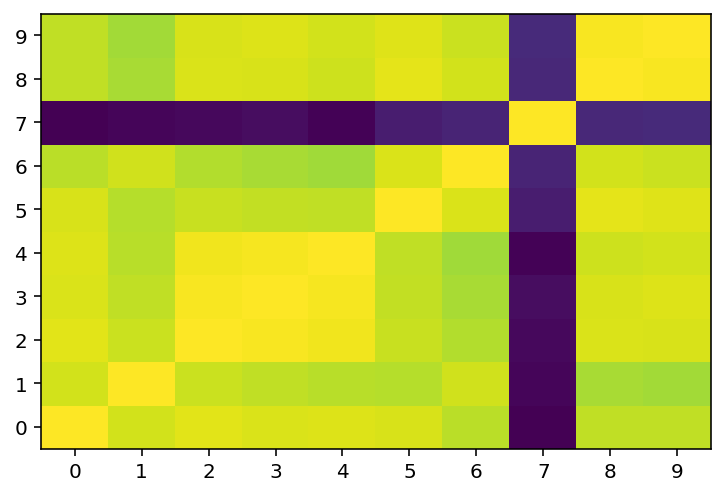

In [99]:
import numpy as np 
import matplotlib.pyplot as plt

index = list(similarity['Index_1'].unique())
columns = list(similarity['Index_2'].unique())
df = pd.DataFrame(0, index=index, columns=columns)

for i in df.index:
    sub = similarity[(similarity['Index_1']==i)]
    for col in df.columns:
        df.loc[i,col]=sub[sub['Index_2']==col][metric].iloc[0]
        
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [100]:
similarity[['Title_1','Index_1','Title_2','Index_2',metric]].sort_values(by=metric,ascending=False)

,Title_1,Index_1,Title_2,Index_2,Cosine_Similarity
99,Alphabet Inc.,9,Alphabet Inc.,9,1.000000
11,AMAZON COM INC,1,AMAZON COM INC,1,1.000000
44,AMAZON COM INC,4,AMAZON COM INC,4,1.000000
33,AMAZON COM INC,3,AMAZON COM INC,3,1.000000
77,Alphabet Inc.,7,Alphabet Inc.,7,1.000000
...,...,...,...,...,...
71,Alphabet Inc.,7,AMAZON COM INC,1,0.602349
74,Alphabet Inc.,7,AMAZON COM INC,4,0.599703
47,AMAZON COM INC,4,Alphabet Inc.,7,0.599703
70,Alphabet Inc.,7,AMAZON COM INC,0,0.597492


## [Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model)

[Bag of Words](https://en.wikipedia.org/wiki/Bag-of-words_model) a way to represent text based on the idea that similar texts will contain similar vocabulary. There is a lot to this model and we provide merely a simple implementation of it here.

In [101]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1,1),analyzer = "word")
data_bow = bow.fit_transform(data['Story'])
data_bow

<15x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 13623 stored elements in Compressed Sparse Row format>

## Sentiment Analysis

Sentiment is a way of measuring the overall positivity or negativity in a given text.

To do this we will use the built in sentiment function in the *TextBlob* package. This function will return the polarity and subjectivity scores for each data chunk.

In [102]:
data['Story'][:5].apply(lambda x: TextBlob(x).sentiment)

0     (0.05206328652547576, 0.36030373468995647)
1      (0.04777951754929917, 0.3545975179322718)
2      (0.04672057393604929, 0.3477917102752281)
3     (0.04960527516001604, 0.34639215360867287)
4    (0.048289163785265696, 0.34750143824204693)
Name: Story, dtype: object

Focusing on the polarity score, we are able to see the overall sentiment of each data chunk. The closer to 1 the more positive and the closer to -1 the more negative.

In [103]:
data['sentiment'] = data['Story'].apply(lambda x: TextBlob(x).sentiment[0] )
data[['Story','sentiment']].head()

,Story,sentiment
0,\n\n\n\n\namzn-20201231false2020FY0001018724P3...,0.052063
1,\n\n\n\n\n\n\n\n\t\n\t\t\n\t\tDocument\n\t\n\t...,0.047780
2,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\nTa...,0.046721
3,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,0.049605
4,\n\n\n\t\n\t\t\n\t\t\n\t\tDocument\n\t\n\t\n U...,0.048289


Here we have textted the sentiment scores for the first 10 chunks.

Notice they tend to be positive but not exceedingly so.

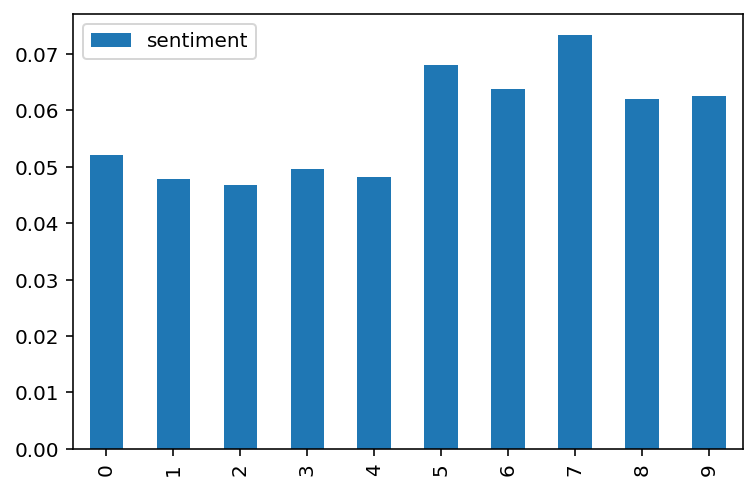

In [104]:
plot_1 = data[['sentiment']][:10].plot(kind='bar')

Now we have sorted and textted all of the sentiment scores for the chunks in our database.

We can clearly see that most of the text data is positive but not overwhelmingly so (as seen by the long tail of the distribution). However, the parts that are negative tend to be more polarized than the positive ones (a shorter tail and sharper peak).

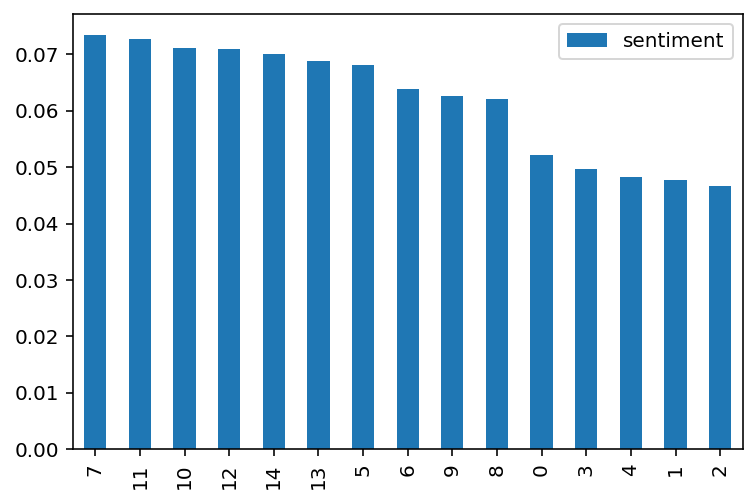

In [105]:
plot_2 = data[['sentiment']].sort_values(by='sentiment', ascending=False).plot(kind='bar')

## Using TF-IDF and Machine Learning

This is significantly more advanced than the rest of the tutorial. This takes the TF-IDF matrix and applies a [k-means clustering algorithm](https://en.wikipedia.org/wiki/K-means_clustering). This groups the texts into clusters of similar terms from the TF-IDF matrix. This algorithm randomly seeds X "means", the values are then clustered into the nearest mean. The centroid of the values in each cluster then becomes the new mean and the process repeats until a convergence is reached.

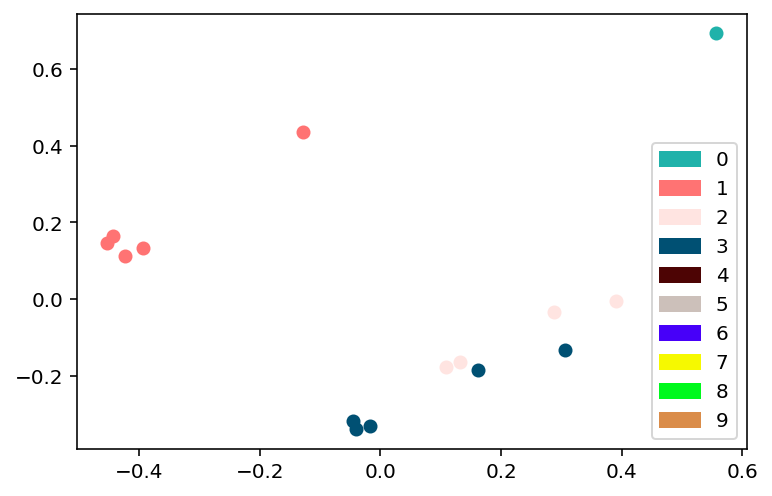

In [127]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

groups = 4

num_clusters = groups
num_seeds = groups
max_iterations = 300
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

# calculate tf-idf of texts
tfidf = TfidfVectorizer(max_features=1000, lowercase=True, analyzer='word',stop_words= 'english',ngram_range=(1,1))
tf_idf_matrix = tfidf.fit_transform(data['Story'])

# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
    precompute_distances="auto",
    n_jobs=-1
)

labels = clustering_model.fit_predict(tf_idf_matrix)
#print(labels)

X = tf_idf_matrix.todense()

# ----------------------------------------------------------------------------------------------------------------------

reduced_data = PCA(n_components=pca_num_components).fit_transform(X)
# print(reduced_data)

import matplotlib.patches as mpatches
legendlist=[mpatches.Patch(color=labels_color_map[key],label=str(key))for key in labels_color_map.keys()]

fig, ax = plt.subplots()
for index, instance in enumerate(reduced_data):
    #print(instance, index, labels[index])
    pca_comp_1, pca_comp_2 = reduced_data[index]
    color = labels_color_map[labels[index]]
    ax.scatter(pca_comp_1, pca_comp_2, c=color)
plt.legend(handles=legendlist)
plt.show()



# t-SNE plot
#embeddings = TSNE(n_components=tsne_num_components)
#Y = embeddings.fit_transform(X)
#plt.scatter(Y[:, 0], Y[:, 1], cmap=plt.cm.Spectral)
#plt.show()


In [128]:
tfidf_test = tf1.sort_values(by='tfidf', ascending=False)[:1000]

In [129]:
title_groups = np.transpose([labels,data['Title'],data['10K_Filing']])

These are the titles of the texts in each cluster. Keep in mind that each time you run the algorithm, the randomness in generating the initial means will result in different clusters.

In [130]:
for i in range(len(title_groups)):
    data.loc[i,'Group'] = title_groups[i][0]

In [131]:
grp=1
data[data['Group']==grp]['Title']#.sample(15)

10    MICROSOFT CORP
11    MICROSOFT CORP
12    MICROSOFT CORP
13    MICROSOFT CORP
14    MICROSOFT CORP
Name: Title, dtype: object

In [132]:
for i in range(groups):
    print("")
    print("#### {} ###".format(i))
    print("")
    for el in title_groups:
        if el[0]==i:
            print("{}".format(el[1]))


#### 0 ###

Alphabet Inc.

#### 1 ###

MICROSOFT CORP
MICROSOFT CORP
MICROSOFT CORP
MICROSOFT CORP
MICROSOFT CORP

#### 2 ###

Alphabet Inc.
Alphabet Inc.
Alphabet Inc.
Alphabet Inc.

#### 3 ###

AMAZON COM INC
AMAZON COM INC
AMAZON COM INC
AMAZON COM INC
AMAZON COM INC
